## Importing modules

In [63]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import scipy.cluster.hierarchy as shc

In [31]:
# Reading train and test data from given csv files

data_train = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')

## Exploratory Data Analysis

First let's see the size of the given datasets and sample some of the rows from it to get the gerenal idea of what's stored in there. We can see that train dataset has 891 entities and 12 features, and test dataset has 418 entities and 11 features ('Survived' column is not present in the test dataset).

In [32]:
print (data_train.shape)
data_train.sample(5)

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
662,663,0,1,"Colley, Mr. Edward Pomeroy",male,47.0,0,0,5727,25.5875,E58,S
633,634,0,1,"Parr, Mr. William Henry Marsh",male,NaN,0,0,112052,0.0000,NaN,S
686,687,0,3,"Panula, Mr. Jaako Arnold",male,14.0,4,1,3101295,39.6875,NaN,S
551,552,0,2,"Sharp, Mr. Percival James R",male,27.0,0,0,244358,26.0000,NaN,S
323,324,1,2,"Caldwell, Mrs. Albert Francis (Sylvia Mae Harb...",female,22.0,1,1,248738,29.0000,NaN,S


In [33]:
print (data_test.shape)
data_test.sample(5)

(418, 11)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
278,1170,2,"Ware, Mr. John James",male,30.0,1,0,CA 31352,21.000,NaN,S
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.250,NaN,S
139,1031,3,"Goodwin, Mr. Charles Frederick",male,40.0,1,6,CA 2144,46.900,NaN,S
407,1299,1,"Widener, Mr. George Dunton",male,50.0,1,1,113503,211.500,C80,C
103,995,3,"Johansson Palmquist, Mr. Oskar Leander",male,26.0,0,0,347070,7.775,NaN,S


From the result above we can see that provided datasets have some missing values and a few categorical features that are represented in 'object' type (sex, Embarked, Ticket, Cabin, Name).

## Missing values

Now let's handle missing values. I want to train a clusterization model using 3 algorithms: K-means, agglomerative hierarchical (different linkages) and DBSCAN. Even hierarchical and DBSCAN algorithms can work with missing data if the corresponding distance metric is specified, K-means algorithm can't work with missing values, so I need to do something about them. Let's output the percentage of missing values in the columns.

In [34]:
total_nan = (data_train.isnull().sum() / data_train.shape[0]) * 100
total_nan[total_nan > 0].sort_values(ascending=False)

Cabin       77.104377
Age         19.865320
Embarked     0.224467
dtype: float64

In [35]:
total_nan_test = (data_test.isnull().sum() / data_test.shape[0]) * 100
total_nan_test[total_nan_test > 0].sort_values(ascending=False)

Cabin    78.229665
Age      20.574163
Fare      0.239234
dtype: float64

From the result above we can see that both train and test datasets have more than 75% of missing values for the Cabin feature, so it might make sense to just drop it. Age is a numerical feature and the percentage of missing values is quite big, but I think it makes sense to replace missing values in the 'Age' column with the median. And because the percentage of missing values for 'Embarked' and 'Fare' features is pretty small, I will just drop the corresponding entries. I will also drop a 'Name' column, because it uniquely identifies people and I don't want to one-hot encode it because it would create a ton of new features, and label-encoding doesn't make sense because these values are not ordinal.

In [36]:
# Dropping Cabin and Name columns
data_test.drop(data_test.columns[data_test.isnull().mean()>0.7],axis=1, inplace=True)
data_train.drop(data_train.columns[data_train.isnull().mean()>0.7],axis=1, inplace=True)

data_test = data_test.drop('Name', axis=1)
data_train = data_train.drop('Name', axis=1)

In [37]:
data_train.sample(5)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
828,829,1,3,male,NaN,0,0,367228,7.7500,Q
621,622,1,1,male,42.0,1,0,11753,52.5542,S
872,873,0,1,male,33.0,0,0,695,5.0000,S
538,539,0,3,male,NaN,0,0,364498,14.5000,S
690,691,1,1,male,31.0,1,0,17474,57.0000,S


In [38]:
# Dropping all entries that have NaN in 'Embarked' feature for train dataset and 'Fare' feature for test dataset
data_train = data_train.dropna(subset=['Embarked'])
data_train = data_train.dropna(subset=['Ticket'])
data_test = data_test.dropna(subset=['Fare'])
data_test = data_test.dropna(subset=['Ticket'])

In [39]:
# Replacing missing values for the 'Age' feature with the mean
mean_age_train = data_train['Age'].mean().round()
mean_age_test = data_test['Age'].mean().round()

data_train['Age'] = data_train['Age'].fillna(mean_age_train)
data_test['Age'] = data_test['Age'].fillna(mean_age_test)

In [40]:
total_nan = (data_train.isnull().sum() / data_train.shape[0]) * 100
total_nan[total_nan > 0].sort_values(ascending=False)

Series([], dtype: float64)

## Handling types

The next step is to convert the categorical data of type 'object' to the numeric representation, because K-means algorithm is distance-based and can't work with textual data. For this step I will use label encoding for the 'sex' feature, and then use one-hot encoding for other textual categorical data, because all the textual categorical features that are present in the datasets are not ordinal.

In [41]:
data_train['Sex'] = data_train['Sex'].map({'female':0,'male':1}).astype(int)
data_test['Sex'] = data_test['Sex'].map({'female':0,'male':1}).astype(int)

In [42]:
columns_to_encode = ['Ticket', 'Embarked']
encoder = OneHotEncoder()

# One-hot encode the categorical features
for col in columns_to_encode:
    col_data = data_train[col].values.reshape(-1, 1)
    col_encoded = encoder.fit_transform(col_data).toarray()
    
    # create new column names based on the categories
    col_categories = encoder.categories_[0]
    new_col_names = [col + '_' + str(category) for category in col_categories]
    # add the new columns to the dataframe
    col_df = pd.DataFrame(col_encoded, columns=new_col_names)
    data_train = pd.concat([data_train, col_df], axis=1)
    
# drop the original columns
data_train = data_train.drop(columns_to_encode, axis=1)

# Test dataset
#for col in columns_to_encode:
    #col_data = data_test[col].values.reshape(-1, 1)
    #col_encoded = encoder.fit_transform(col_data).toarray()
    
    # create new column names based on the categories
   # col_categories = encoder.categories_[0]
   # new_col_names = [col + '_' + str(category) for category in col_categories]
    # add the new columns to the dataframe
   # col_df = pd.DataFrame(col_encoded, columns=new_col_names)
   # data_test = pd.concat([data_train, col_df], axis=1)
    
# drop the original columns
#data_test = data_test.drop(columns_to_encode, axis=1)

In [43]:
data_train.sample(5)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Ticket_110152,Ticket_110413,...,Ticket_W./C. 6607,Ticket_W./C. 6608,Ticket_W./C. 6609,Ticket_W.E.P. 5734,Ticket_W/C 14208,Ticket_WE/P 5735,Embarked_C,Embarked_Q,Embarked_S,Embarked_nan
49,50.0,0.0,3.0,0.0,18.0,1.0,0.0,17.8000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
297,298.0,0.0,1.0,0.0,2.0,1.0,2.0,151.5500,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
710,711.0,1.0,1.0,0.0,24.0,0.0,0.0,49.5042,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,2.0,1.0,1.0,0.0,38.0,1.0,0.0,71.2833,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
294,295.0,0.0,3.0,1.0,24.0,0.0,0.0,7.8958,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## Training models

First let's train our clusterization model using k-means algorithm with different number of predefined clusters and see what the results are.

In [44]:
data_train.dropna(inplace=True)
# Scaling data
scaler = StandardScaler()
scaled_train = scaler.fit_transform(data_train)
#scaled_test = scaler.transform(data_test)

# Specifying the number of clusters
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters)

# Fitting the KMeans model to the scaled training data
kmeans.fit(scaled_train)

KMeans(n_clusters=3)

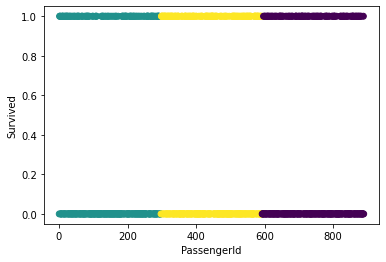

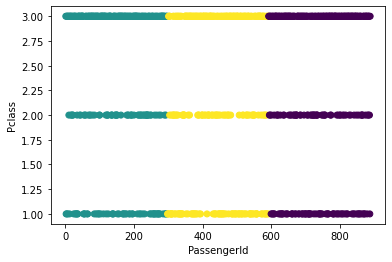

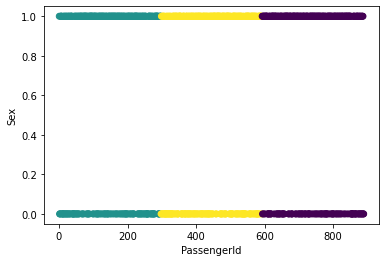

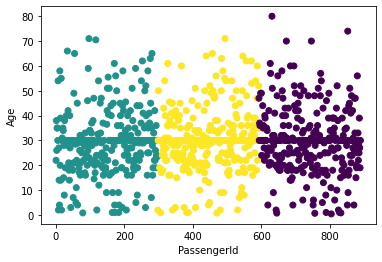

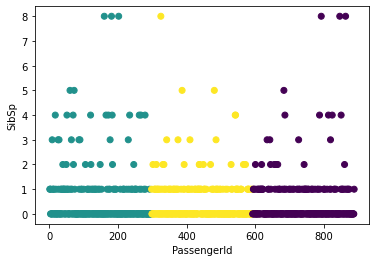

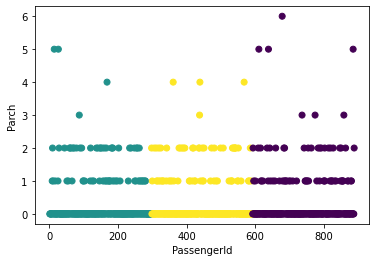

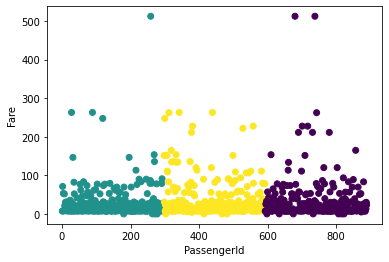

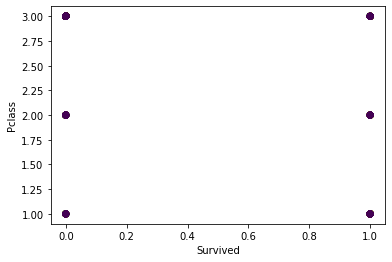

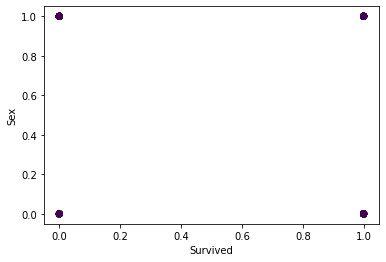

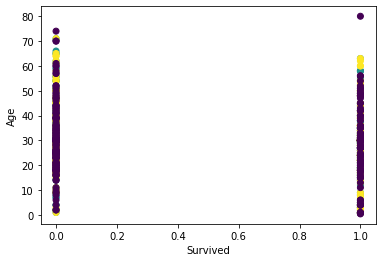

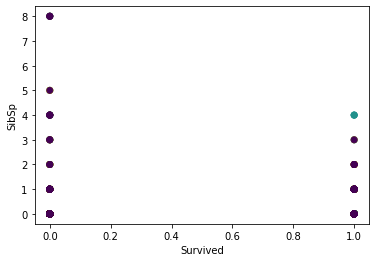

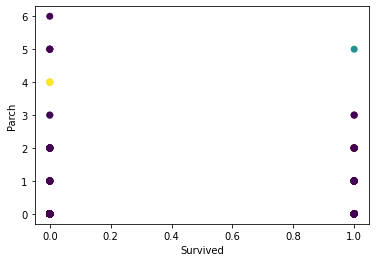

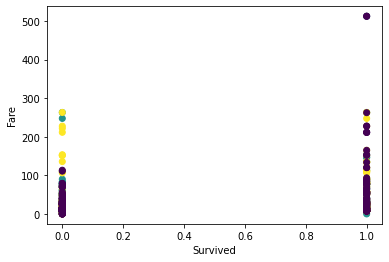

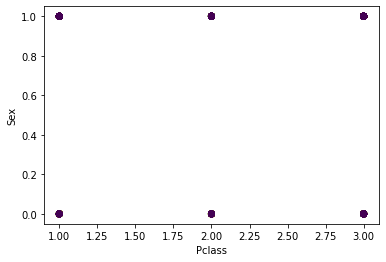

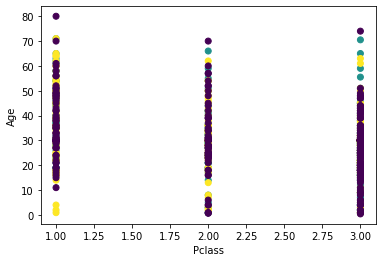

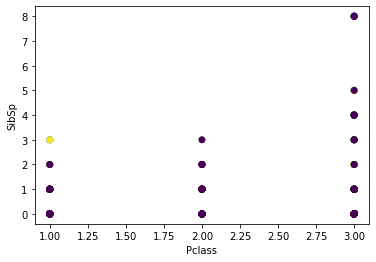

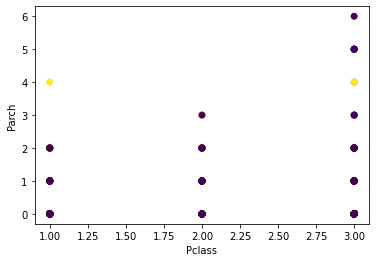

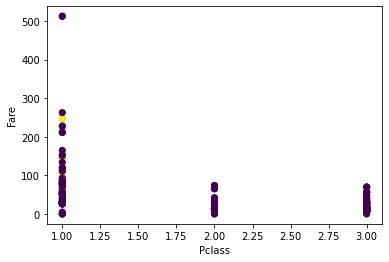

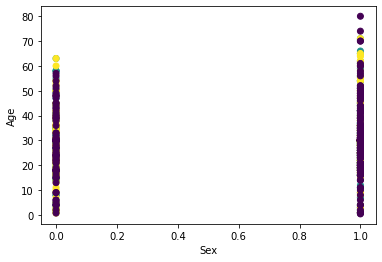

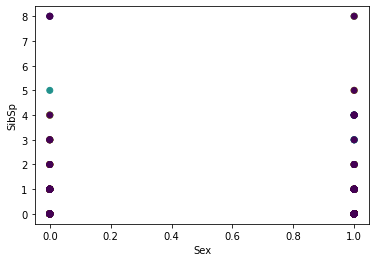

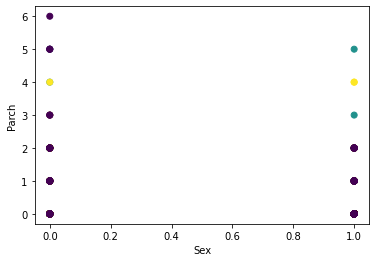

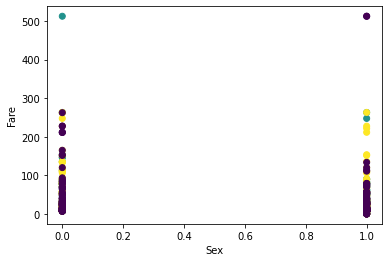

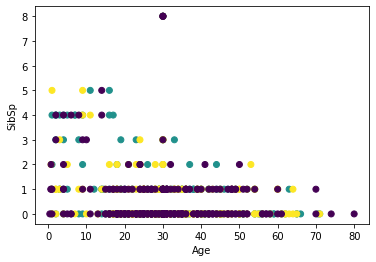

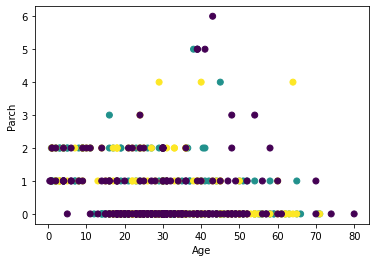

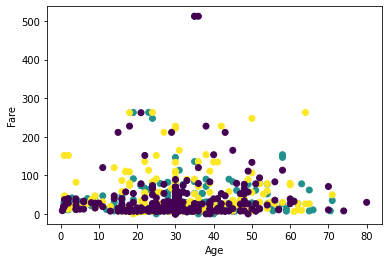

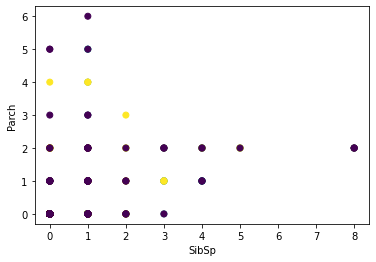

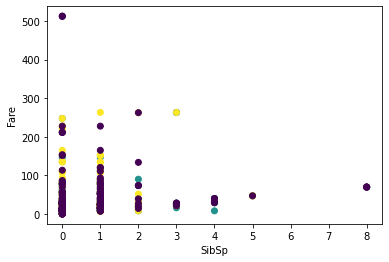

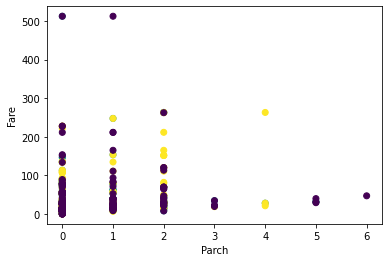

In [49]:
y_kmeans = kmeans.fit_predict(data_train)
names = ['PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']
for i in range(8):
    for j in range(i + 1, 8):
        plt.scatter(data_train.iloc[:, i], data_train.iloc[:, j], c=y_kmeans, cmap='viridis')
        plt.xlabel(names[i])
        plt.ylabel(names[j])
        plt.show()

From the result above we can see that for some of the features (PassangerId + Parch), (PassengerId, Fare) the division into 3 clusters is pretty clear, while for others it might not make sense (like Age + Survived). This might be due to the fact that there are some features that were created using one-hot encoding that are not represented on the graphs above. Now let's see how the graphs would look like if we try to create 10 clusters.

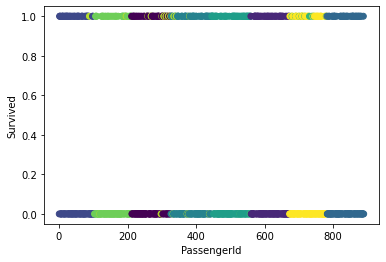

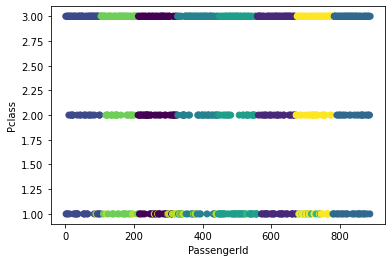

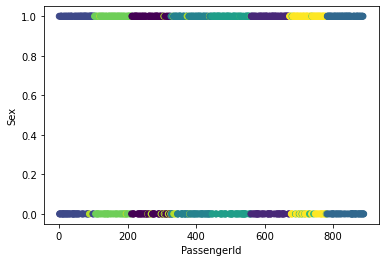

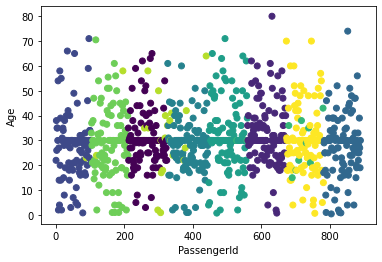

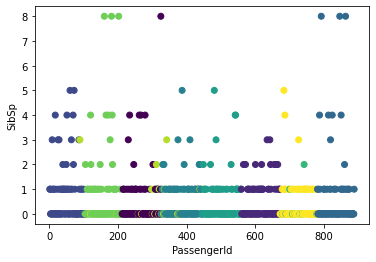

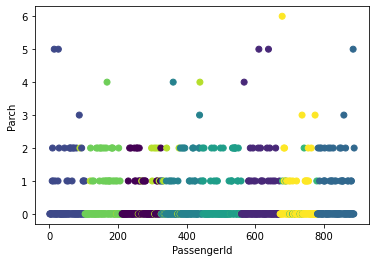

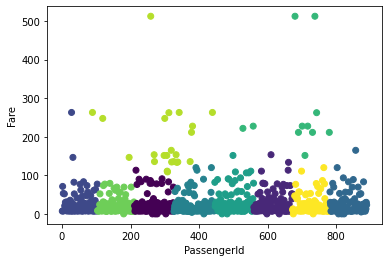

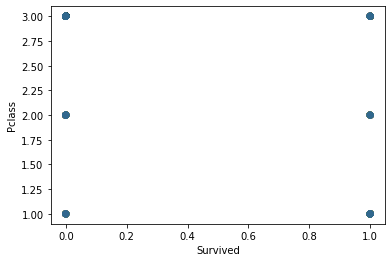

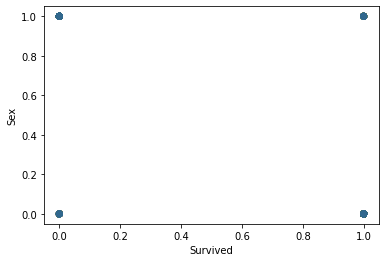

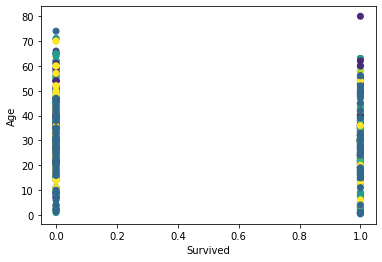

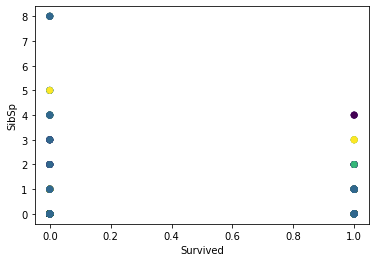

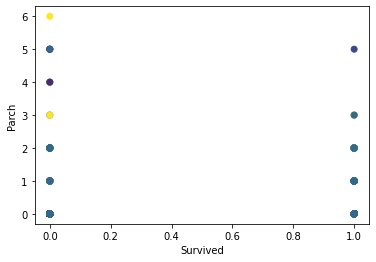

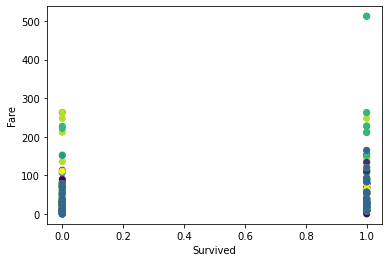

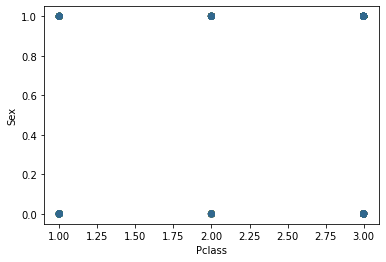

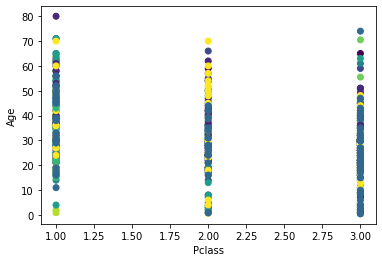

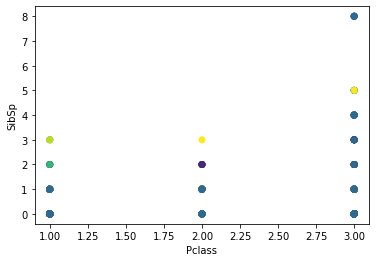

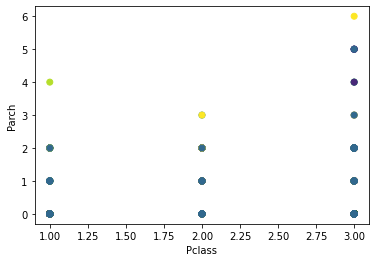

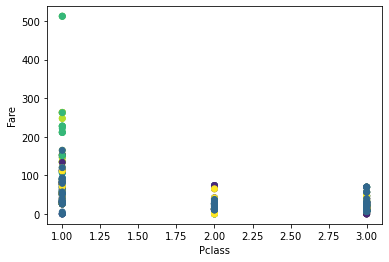

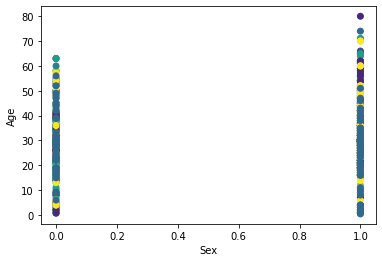

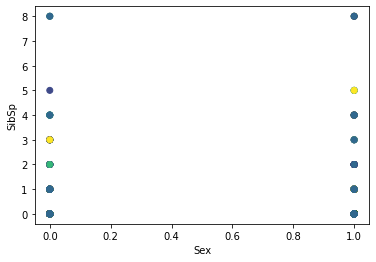

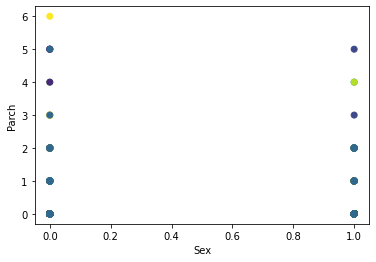

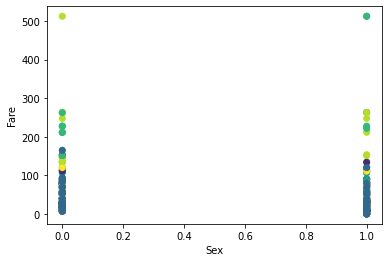

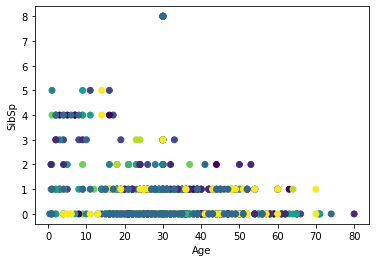

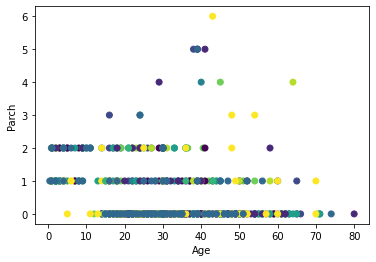

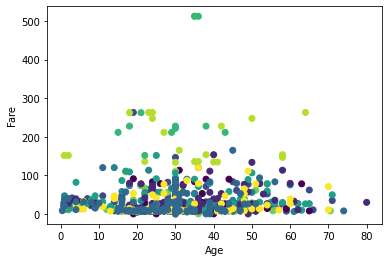

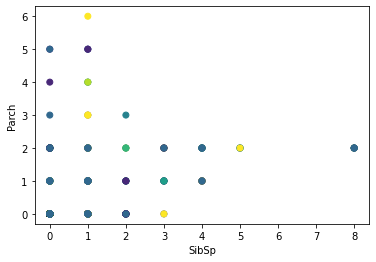

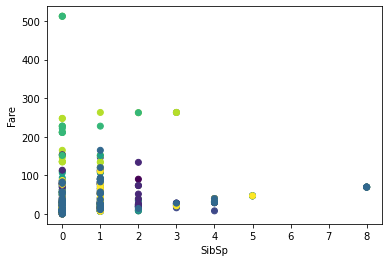

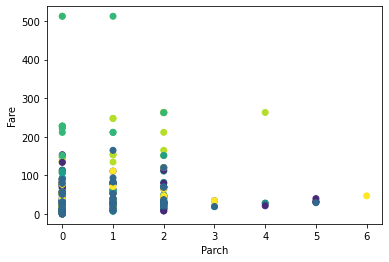

In [50]:
# Specifying the number of clusters
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters)

# Fitting the KMeans model to the scaled training data
kmeans.fit(scaled_train)

y_kmeans = kmeans.fit_predict(data_train)
names = ['PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']
for i in range(8):
    for j in range(i + 1, 8):
        plt.scatter(data_train.iloc[:, i], data_train.iloc[:, j], c=y_kmeans, cmap='viridis')
        plt.xlabel(names[i])
        plt.ylabel(names[j])
        plt.show()

Now let's try to use agglomerative hierarchial algorithm with 2 different linkages: Ward and complete link.

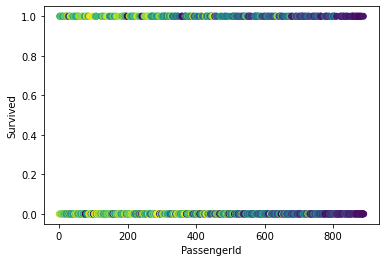

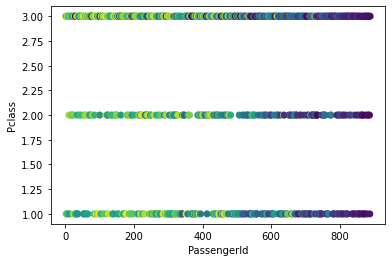

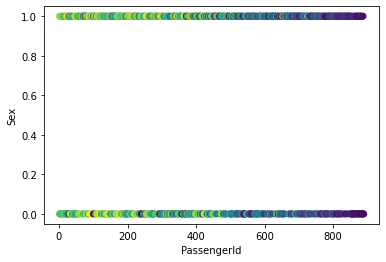

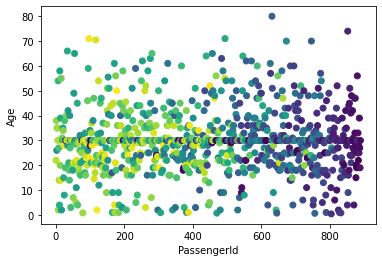

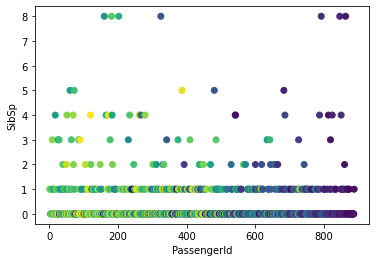

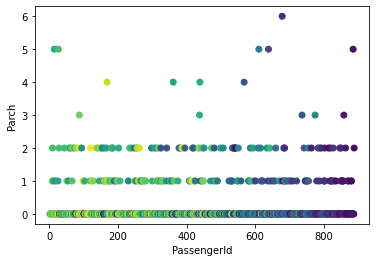

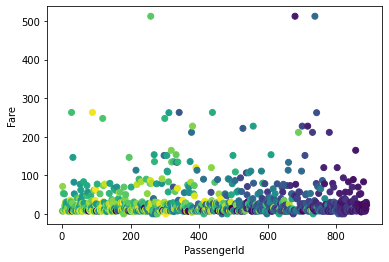

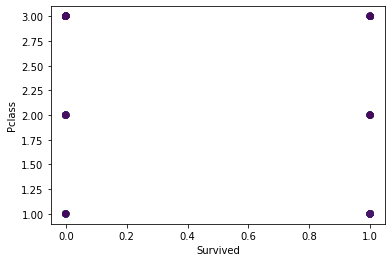

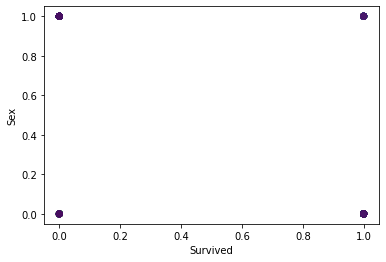

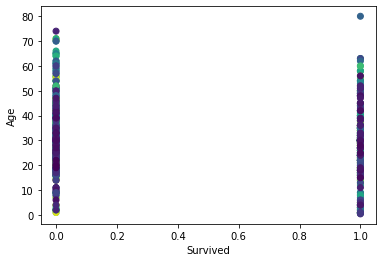

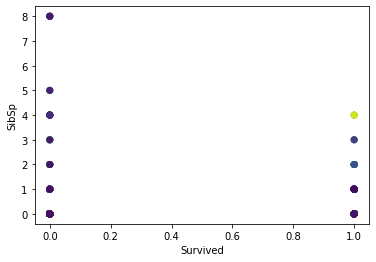

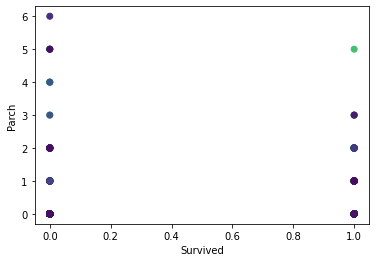

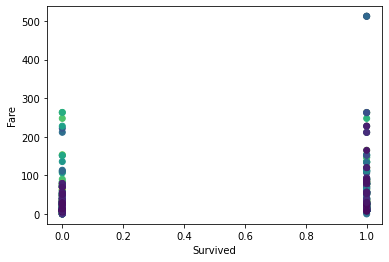

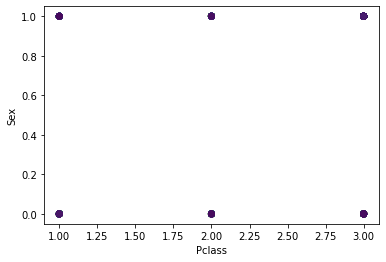

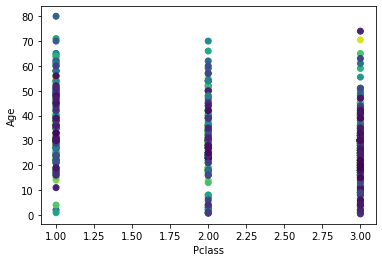

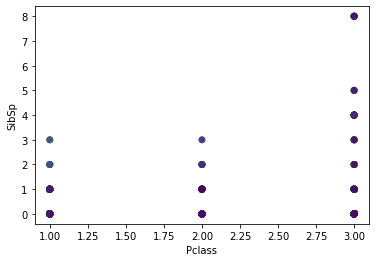

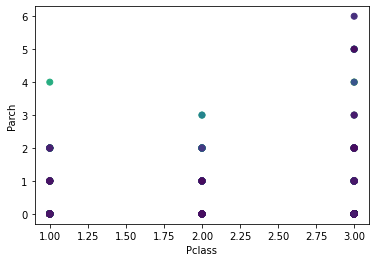

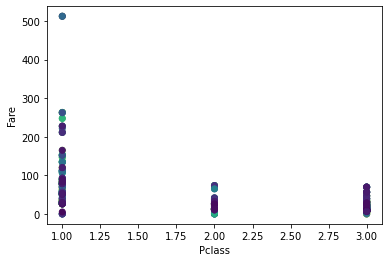

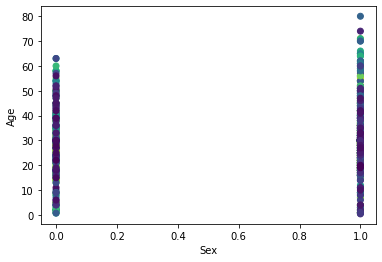

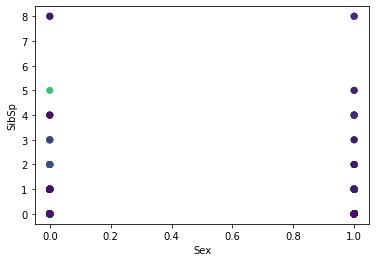

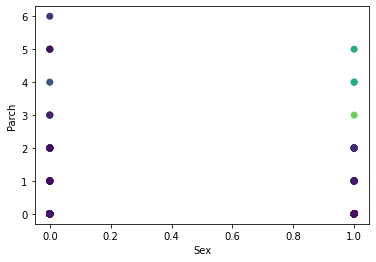

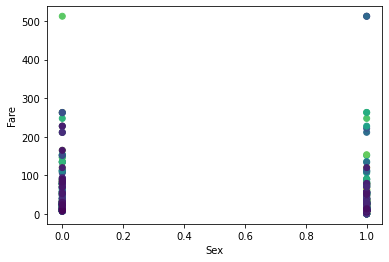

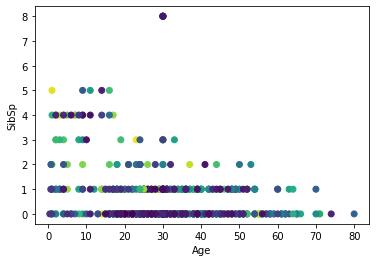

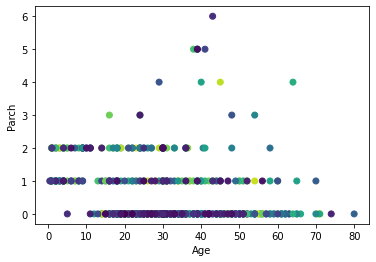

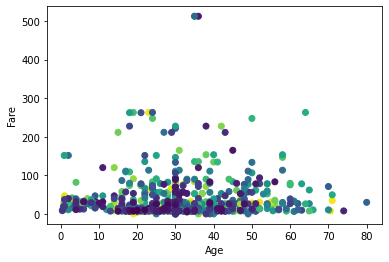

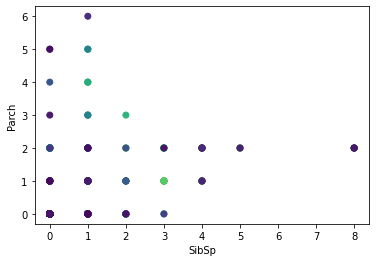

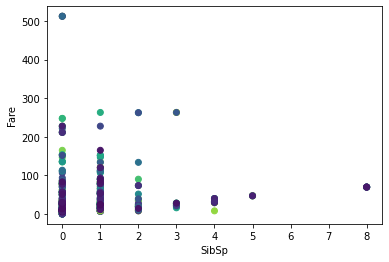

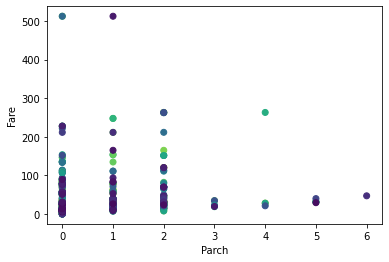

In [61]:
agg_clustering = AgglomerativeClustering(linkage='ward', distance_threshold=3, n_clusters=None)
# fit the clustering model to the data
agg_clustering.fit(scaled_train)

y_agg = agg_clustering.fit_predict(data_train)
names = ['PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']
for i in range(8):
    for j in range(i + 1, 8):
        plt.scatter(data_train.iloc[:, i], data_train.iloc[:, j], c=y_agg, cmap='viridis')
        plt.xlabel(names[i])
        plt.ylabel(names[j])
        plt.show()

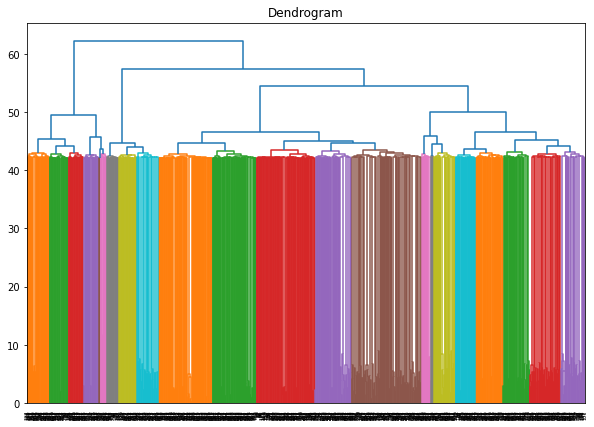

In [58]:
# plot dendrogram
plt.figure(figsize=(10, 7))
plt.title("Dendrogram")
dend = shc.dendrogram(shc.linkage(scaled_train, method='ward'))
plt.show()

From the given dendrogram we can indentify the distance threshold or the number of clusters that we want to divide out dataset into. From what I tested, the bigger distance threshold is, the less clusters we get as the result. Now let's apply complete link method.

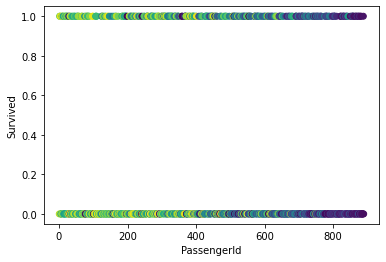

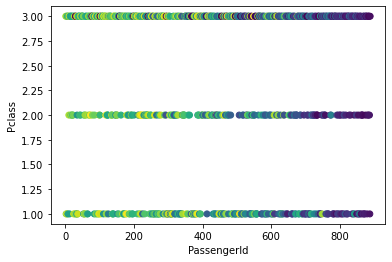

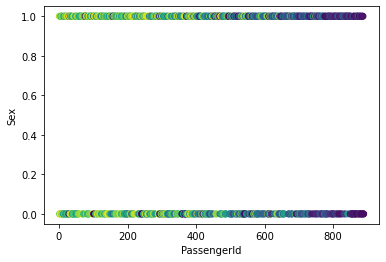

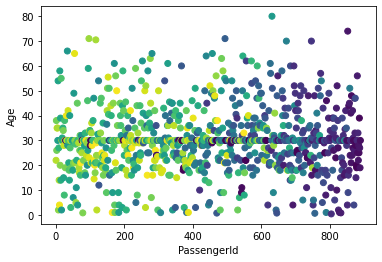

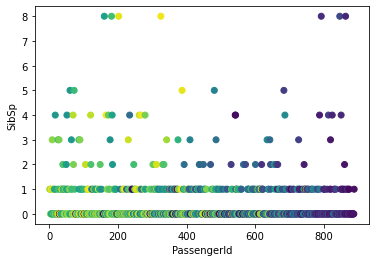

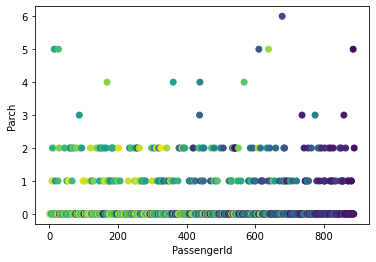

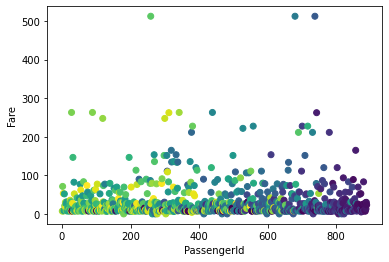

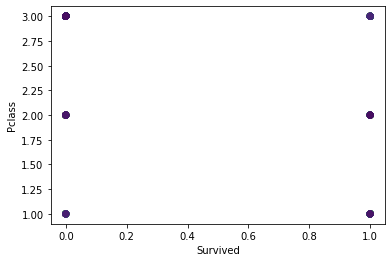

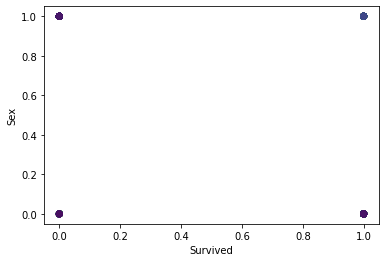

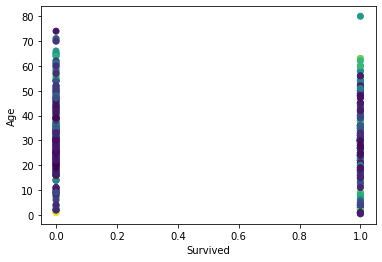

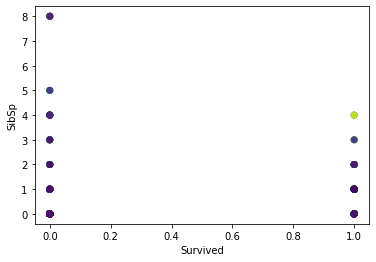

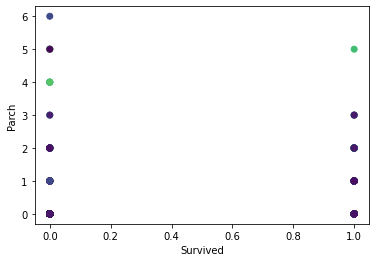

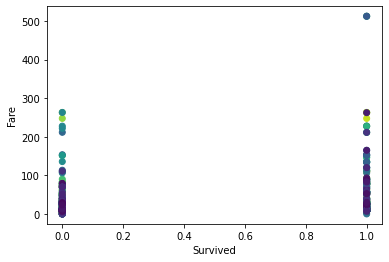

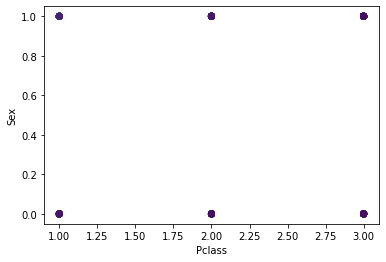

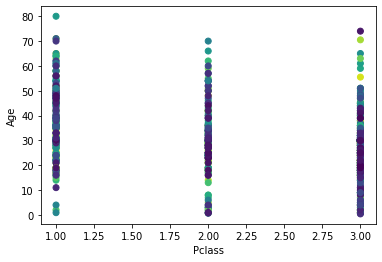

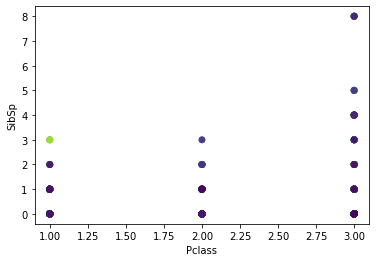

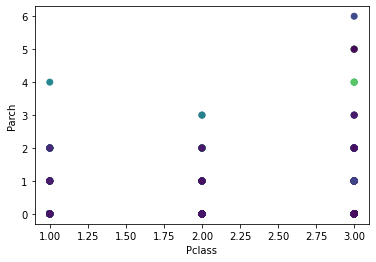

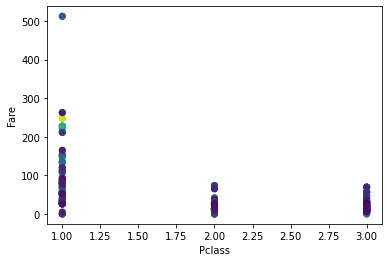

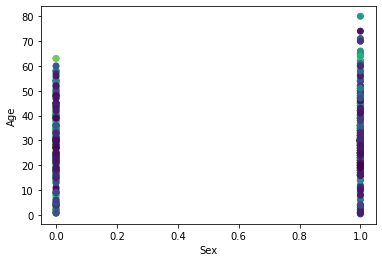

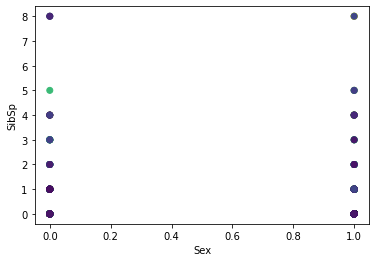

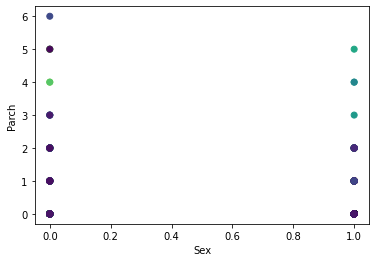

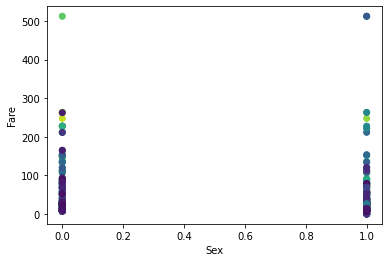

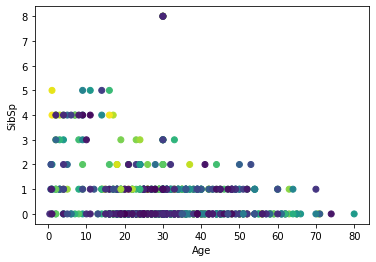

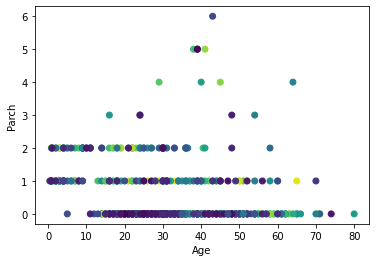

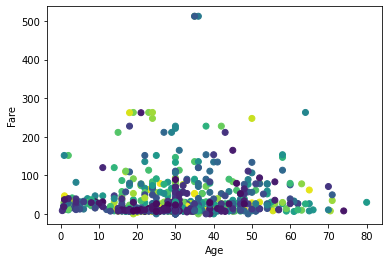

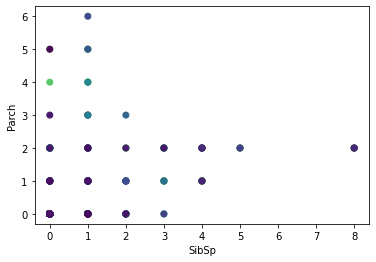

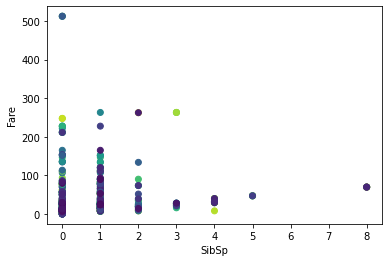

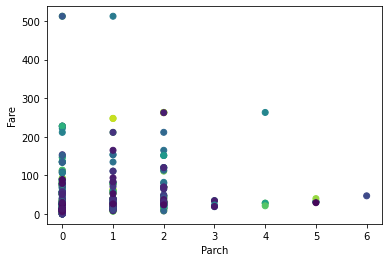

In [60]:
agg_clustering = AgglomerativeClustering(linkage='complete', distance_threshold=3, n_clusters=None)
# fit the clustering model to the data
agg_clustering.fit(scaled_train)

y_agg = agg_clustering.fit_predict(data_train)
names = ['PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']
for i in range(8):
    for j in range(i + 1, 8):
        plt.scatter(data_train.iloc[:, i], data_train.iloc[:, j], c=y_agg, cmap='viridis')
        plt.xlabel(names[i])
        plt.ylabel(names[j])
        plt.show()

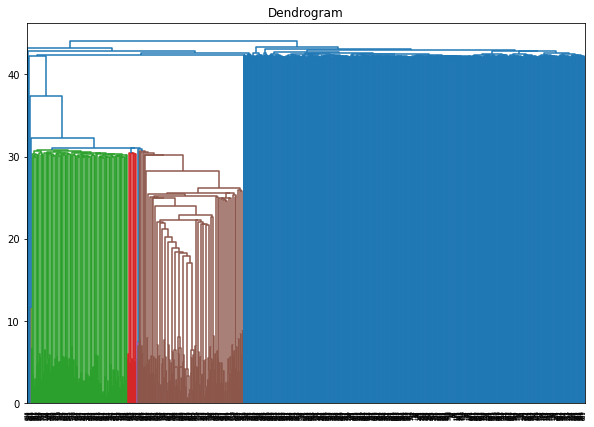

In [62]:
# plot dendrogram
plt.figure(figsize=(10, 7))
plt.title("Dendrogram")
dend = shc.dendrogram(shc.linkage(scaled_train, method='complete'))
plt.show()

From 2 different dendrograms we can see that the agglomerative hierarchial algorithm with ward's linking is dividing the dataset into much more clusters, than with the complete linking.

Now let's train our clusterization model with the DBSCAN algorithm, that requires two parameters: eps and min_samples. eps is the maximum distance between two samples for them to be considered as part of the same cluster, and
min_samples is the minimum number of points required to form a dense region. Points that have at least min_samples neighbors within distance eps are considered as core points.

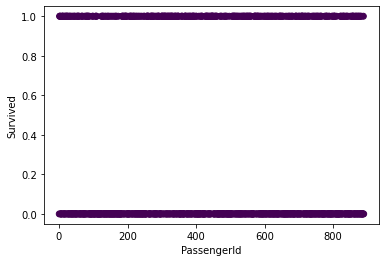

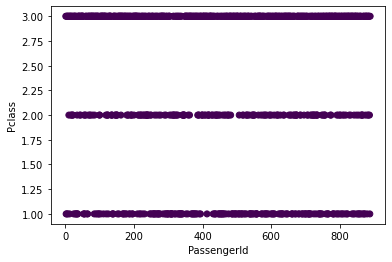

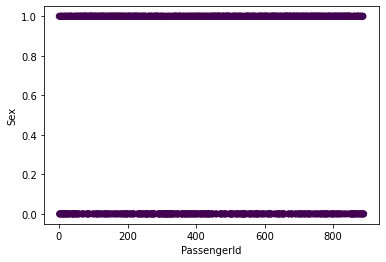

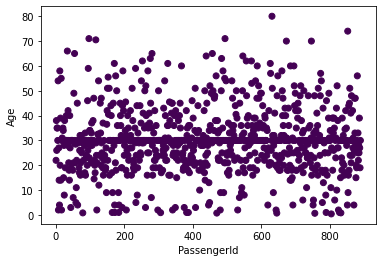

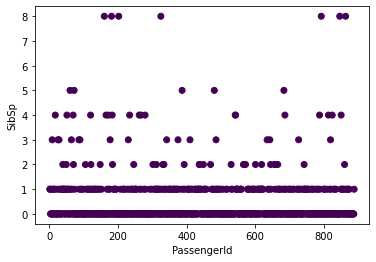

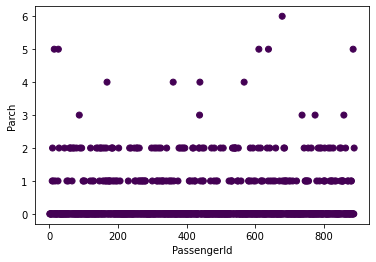

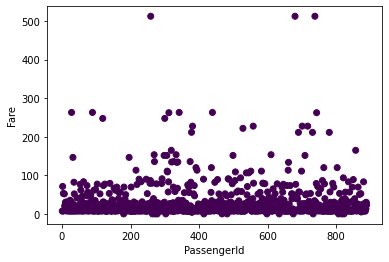

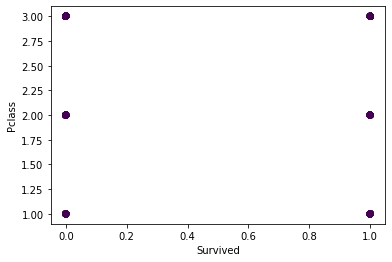

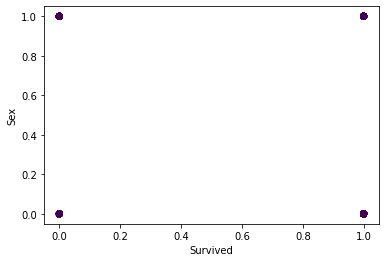

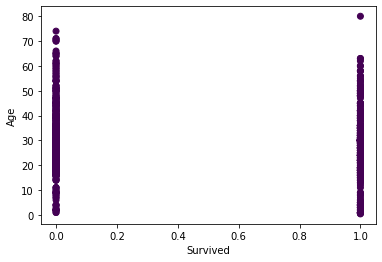

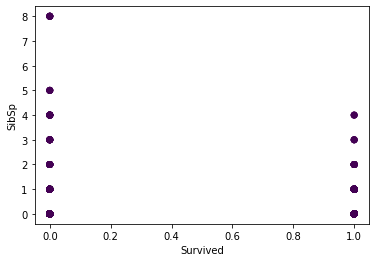

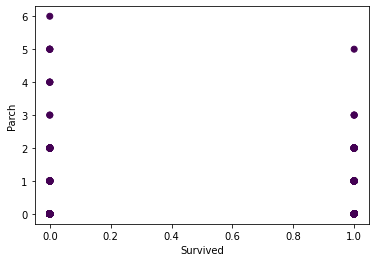

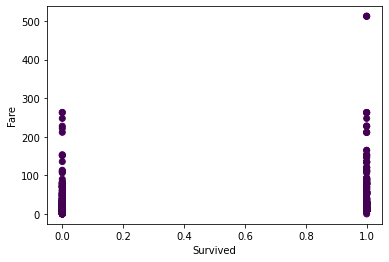

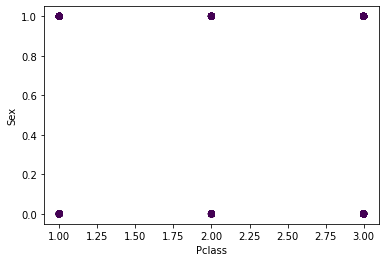

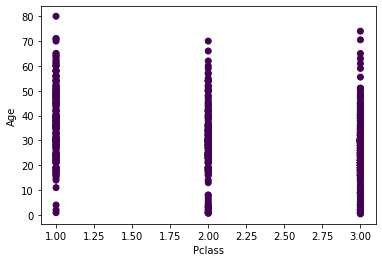

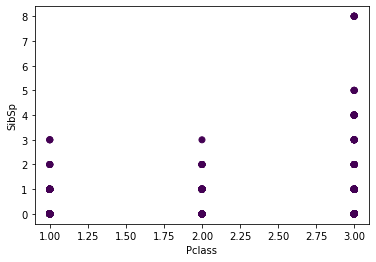

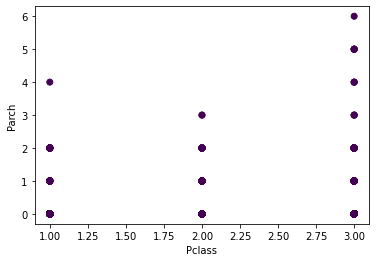

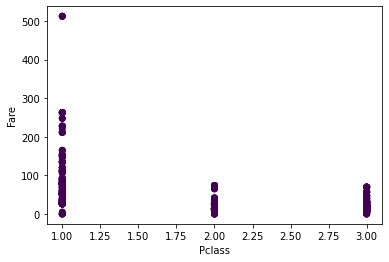

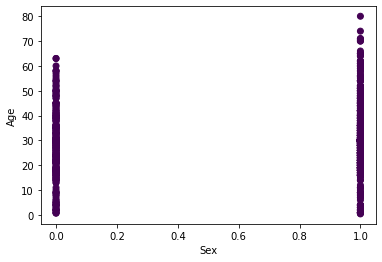

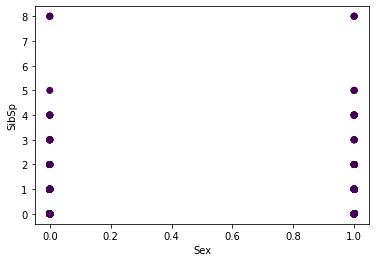

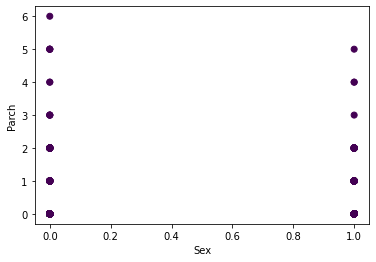

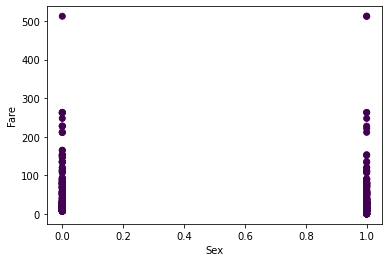

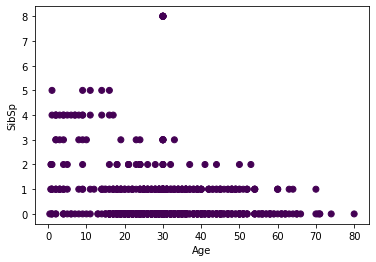

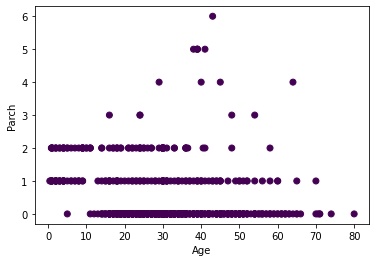

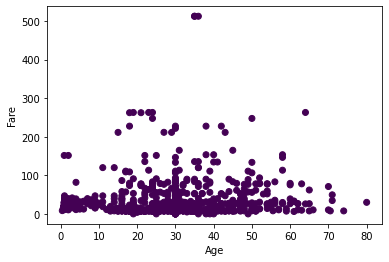

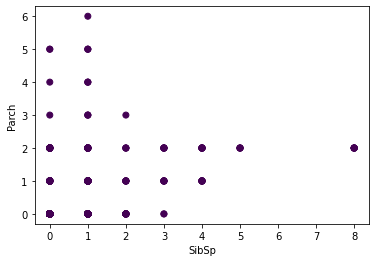

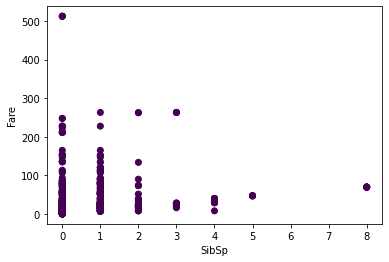

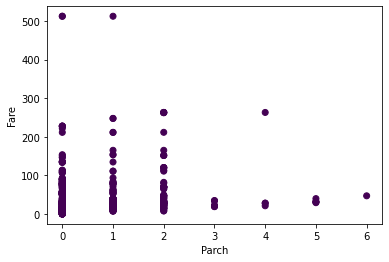

In [64]:
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan.fit(scaled_train)

y_db = dbscan.fit_predict(data_train)
names = ['PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']
for i in range(8):
    for j in range(i + 1, 8):
        plt.scatter(data_train.iloc[:, i], data_train.iloc[:, j], c=y_db, cmap='viridis')
        plt.xlabel(names[i])
        plt.ylabel(names[j])
        plt.show()

We can see that on the first try our parameters for the dbscan are not valid, because we got everything into 1 cluster. Let's try to run the algorithm with the different set of parameters:

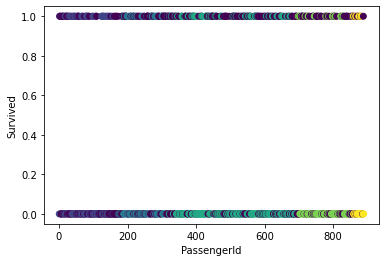

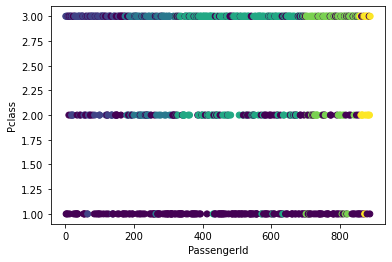

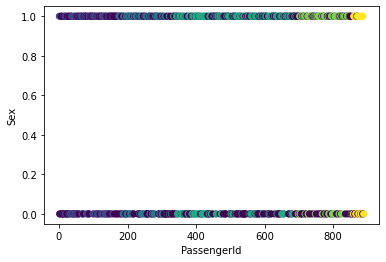

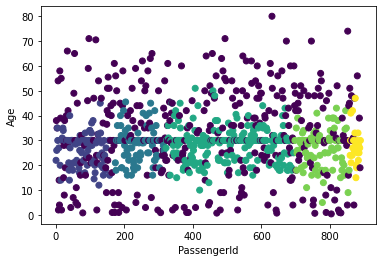

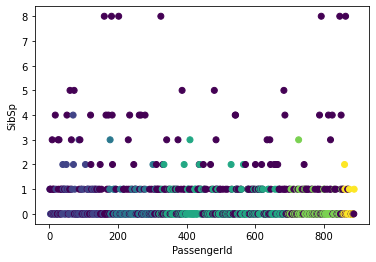

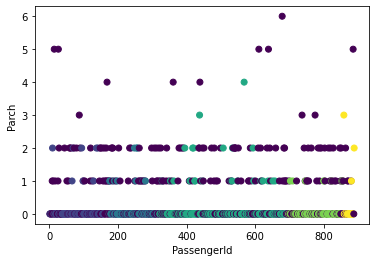

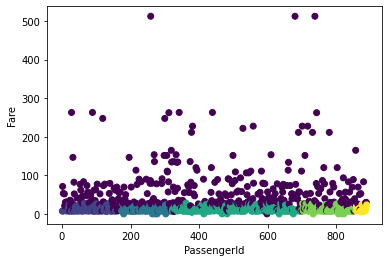

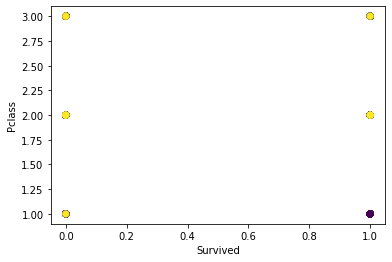

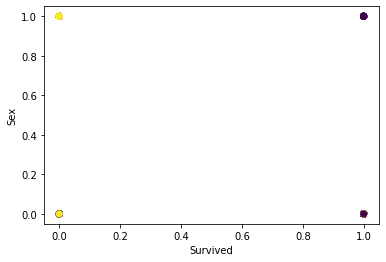

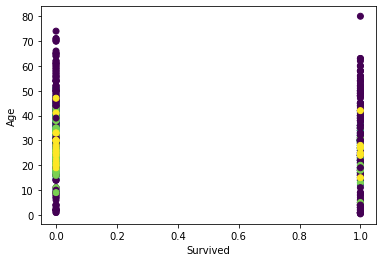

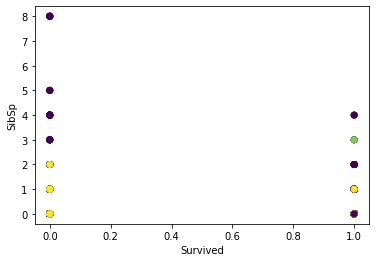

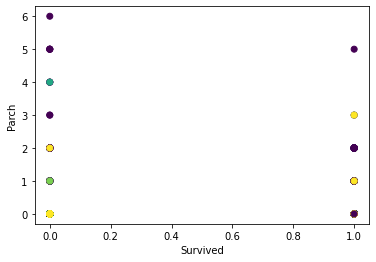

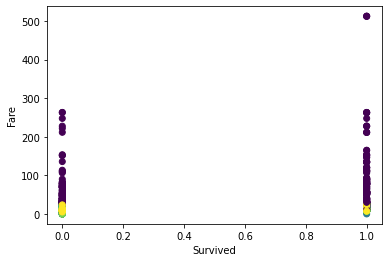

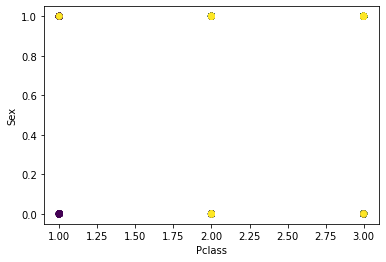

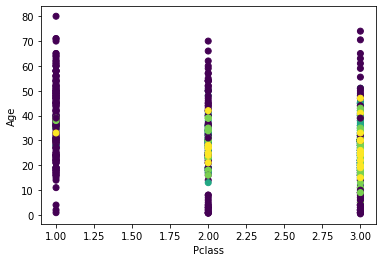

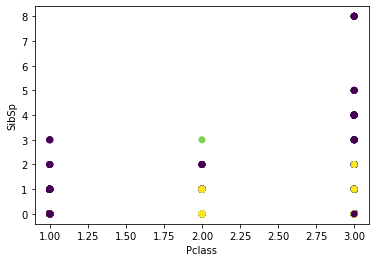

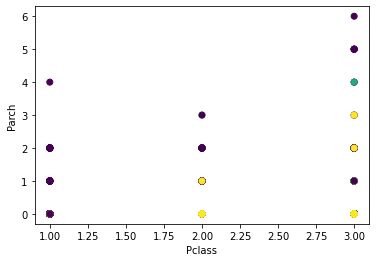

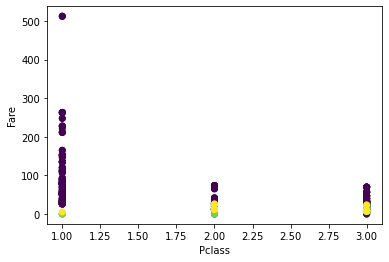

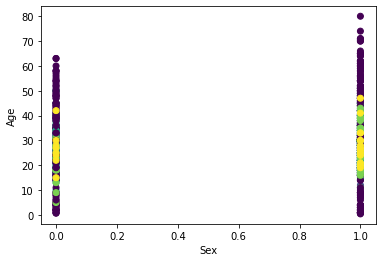

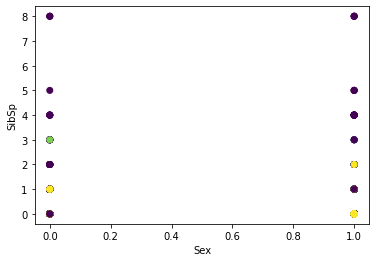

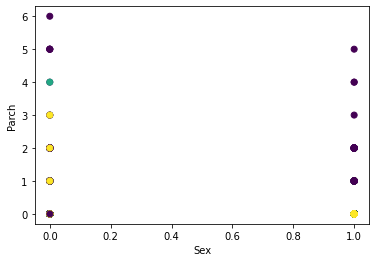

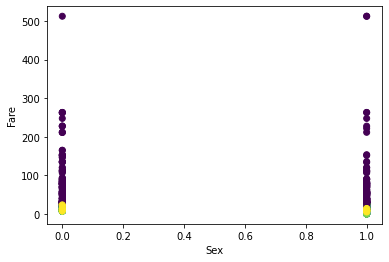

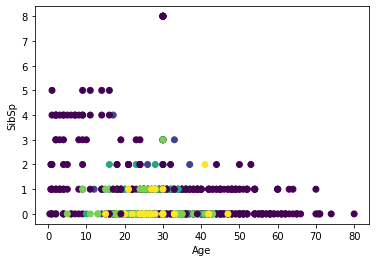

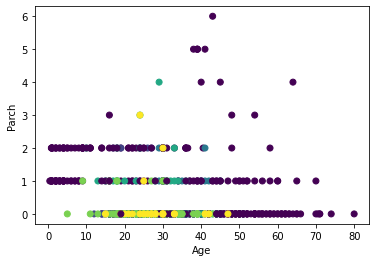

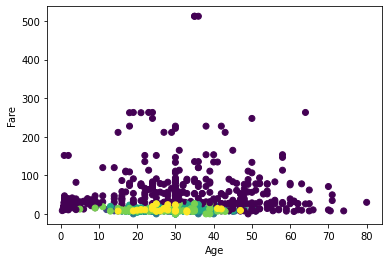

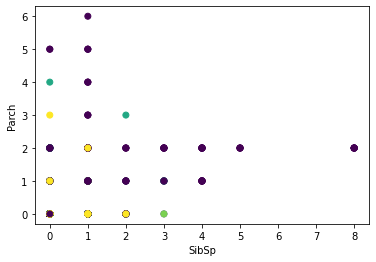

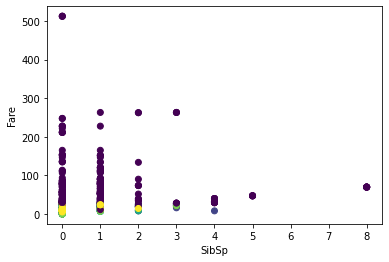

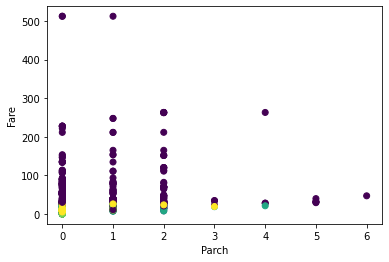

In [72]:
dbscan = DBSCAN(eps=15, min_samples=10)
dbscan.fit(scaled_train)

y_db = dbscan.fit_predict(data_train)
names = ['PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']
for i in range(8):
    for j in range(i + 1, 8):
        plt.scatter(data_train.iloc[:, i], data_train.iloc[:, j], c=y_db, cmap='viridis')
        plt.xlabel(names[i])
        plt.ylabel(names[j])
        plt.show()

By experimenting with the eps and min_samples parameters I discovered that increasing eps and decreasing min_samples results in more clusters. Furthemore, DBSCAN might not be a viable algorithm for some data.